In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 10)

/Users/conorohalloran/Documents/ChiFinesse/march_madness/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load the data!

In [3]:
tourney_results = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    '../../data/MRegularSeasonDetailedResults.csv')


In [4]:
tourney_results.shape

(1115, 34)

In [5]:
seeds.shape

(2354, 3)

In [6]:
regular_results.shape

(96687, 34)

In [7]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [8]:
regular_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,...,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,...,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,...,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,...,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,...,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,...,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,...,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,...,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,...,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,...,11.180518,14.131910,5.933283,2.961685,20.081395


In [9]:
tourney_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,...,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,...,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,...,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,...,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,...,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,...,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,...,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,...,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,...,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,...,11.447761,11.656716,5.701493,2.820896,18.313433


In [10]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [11]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,...,16,15,5,0,22
1,2003,136,1112,80,1436,...,12,17,10,3,15
2,2003,136,1113,84,1272,...,11,12,2,5,18
3,2003,136,1141,79,1166,...,20,21,6,6,21
4,2003,136,1143,76,1301,...,16,14,5,8,19


In [12]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [13]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [14]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [15]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [16]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,...,13,23,7,1,22
1,2003,10,1393,63,1272,...,16,13,4,4,18
2,2003,11,1437,61,1266,...,15,10,5,2,25
3,2003,11,1457,50,1296,...,11,12,14,2,18
4,2003,11,1208,71,1400,...,12,14,4,4,20


In [17]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [18]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [19]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,...,13,23,7,1,22
1,2003,10,1393,63,1272,...,16,13,4,4,18
2,2003,11,1437,61,1266,...,15,10,5,2,25
3,2003,11,1457,50,1296,...,11,12,14,2,18
4,2003,11,1208,71,1400,...,12,14,4,4,20


In [19]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [20]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [21]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [20]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [21]:
regular_data.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1104,68,1328,...,8,18,9,2,20
2,2003,10,1272,70,1393,...,7,12,8,6,16
3,2003,10,1272,70,1393,...,7,12,8,6,16
4,2003,11,1266,73,1437,...,9,12,2,5,23
5,2003,11,1266,73,1437,...,9,12,2,5,23
6,2003,11,1296,56,1457,...,9,19,4,3,23
7,2003,11,1296,56,1457,...,9,19,4,3,23
8,2003,11,1400,77,1208,...,12,10,7,1,14
9,2003,11,1400,77,1208,...,12,10,7,1,14


In [23]:
tourney_results = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    '../../data/MRegularSeasonDetailedResults.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [24]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [25]:
regular_data.shape

(193374, 35)

In [26]:
tourney_data.shape

(2230, 35)

In [27]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
2225,2019,146,1246,71,1120,...,9,10,7,21,-6
2226,2019,146,1181,67,1277,...,7,11,3,11,-1
2227,2019,152,1277,51,1403,...,7,4,4,18,-10
2228,2019,152,1120,62,1438,...,8,1,9,12,-1
2229,2019,154,1403,77,1438,...,11,4,3,15,-8


In [28]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,...,18,9,2,20,6
1,2003,10,1272,70,1393,...,12,8,6,16,7
2,2003,11,1266,73,1437,...,12,2,5,23,12
3,2003,11,1296,56,1457,...,19,4,3,23,6
4,2003,11,1400,77,1208,...,10,7,1,14,6


In [29]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,...,15,5,0,22,8
1,2003,136,1112,80,1436,...,17,10,3,15,29
2,2003,136,1113,84,1272,...,12,2,5,18,13
3,2003,136,1141,79,1166,...,21,6,6,21,6
4,2003,136,1143,76,1301,...,14,5,8,19,2


# Feature engineering!

In [31]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [30]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [31]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  ...  \
                       mean       mean      mean       mean       mean  ...   
Season T1_TeamID                                                        ...   
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571  ...   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778  ...   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429  ...   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000  ...   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714  ...   

                     T2_Ast      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean       mean      mean      mean      mean  
Season T1_TeamID                                                      
2003   1102        9.142857  12.964286  5.428571  1.571429  0.250000  
       1103       15.481481  15.333333  6.407407  2.851852  0.629630  
       1104       11.678571  13.857143  5.535714  3.178571  4.285714  
       1105       15.807692  18.807692  9.384615  4.192308 -4.884615  
       1106       11.785714  15.071429  8.785714  3.178571 -0.142857  

[5 rows x 19 columns]

In [32]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,...,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [33]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [34]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [35]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [38]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [39]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [36]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [37]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [38]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,...,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,...,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,...,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,...,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,...,12.566667,14.633333,7.433333,2.833333,4.400000


In [39]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [40]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [41]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d'],
      dtype='object')

In [42]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(10462, 5)

In [43]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [44]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
2225,2019,146,1246,71,1120,...,5.911765,3.676471,10.294118,0.750000,1.000000
2226,2019,146,1181,67,1277,...,6.411765,2.941176,13.294118,0.800000,1.000000
2227,2019,152,1277,51,1403,...,6.437500,2.468750,13.812500,1.000000,0.666667
2228,2019,152,1120,62,1438,...,5.187500,2.750000,16.781250,1.000000,0.750000
2229,2019,154,1403,77,1438,...,5.187500,2.750000,16.781250,0.666667,0.750000


In [49]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [50]:
seeds.tail()

,Season,Seed,TeamID
2349,2021,Z12,1457
2350,2021,Z13,1317
2351,2021,Z14,1159
2352,2021,Z15,1331
2353,2021,Z16,1216


In [45]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [46]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [47]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [54]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,11.606061,13.848485,12.636364,6.030303,16.303030,23.303030,57.787879,7.757576,22.151515,9.333333,11.242424,12.545455,5.666667,3.000000,11.303030,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,2,5
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,13.382353,15.911765,13.117647,9.470588,15.852941,25.235294,63.852941,6.500000,22.117647,11.970588,12.294118,14.764706,6.529412,3.176471,15.941176,27.764706,57.176471,8.294118,21.617647,10.823529,18.941176,12.852941,5.235294,16.911765,23.323529,61.705882,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,1,2
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,10.823529,18.941176,12.852941,5.235294,16.911765,23.323529,61.705882,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,26.156250,55.468750,7.250000,19.718750,8.843750,14.031250,12.375000,7.375000,17.781250,19.562500,53.093750,6.343750,21.062500,10.125000,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667,2,3
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,25.625000,53.593750,8.468750,20.718750,8.875000,14.500000,9.031250,5.625000,14.656250,19.875000,52.343750,5.812500,21.406250,9.000000,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000,5,1
2229,2019,154,1403,77,1438,85,26.156250,55.468750,7.250000,19.718750,8.843750,14.031250,12.375000,7.375000,17.781250,19.562500,53.093750,6.343750,21.062500,10.125000,9.531250,15.656250,6.437500,2.468750,13.812500,25.625000,53.593750,8.468750,20.718750,8.875000,14.500000,9.031250,5.625000,14.656250,19.875000,52.343750,5.812500,21.406250,9.000000,8.718750,11.000000,5.187500,2.750000,16.781250,0.666667,0.750000,3,1


In [49]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [50]:
tourney_data[tourney_data["Seed_diff"] == 0]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,...,1.000000,0.833333,16,16,0
64,2004,134,1197,72,1250,...,0.600000,1.000000,16,16,0
128,2005,134,1324,79,1105,...,1.000000,0.666667,16,16,0
191,2005,154,1314,75,1228,...,0.750000,0.800000,1,1,0
192,2006,134,1284,71,1214,...,0.750000,0.666667,16,16,0
...,...,...,...,...,...,...,...,...,...,...,...
2161,2018,152,1242,79,1437,...,0.800000,1.000000,1,1,0
2163,2019,134,1396,70,1125,...,0.666667,0.500000,11,11,0
2164,2019,134,1341,76,1192,...,1.000000,1.000000,16,16,0
2165,2019,135,1385,65,1113,...,0.333333,0.666667,11,11,0


# Time to build some models!

In [51]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2230.000000
mean        0.000000
std        14.342819
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [52]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"]

len(features)

43

In [53]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [54]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [55]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [56]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[10:14:37] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:14:37] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Pleas

In [57]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([121, 90, 106], [8.8649652, 8.8367624, 8.872612])

In [58]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[10:15:13] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:15:14] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Pleas

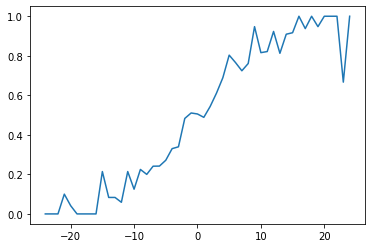

In [59]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [60]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5469422952891579
logloss of cvsplit 1: 0.5446097525651622
logloss of cvsplit 2: 0.5431422621421088


/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/ipykernel_26726/1482360335.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()


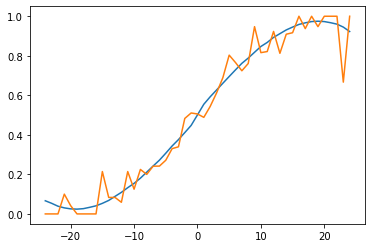

In [61]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [62]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5469496712227199
adjusted logloss of cvsplit 1: 0.5446342509388772
adjusted logloss of cvsplit 2: 0.5431951430601724


In [64]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.3109784800124418
adjusted logloss of cvsplit 1: 1.3092920771596328
adjusted logloss of cvsplit 2: 1.3076751413072383


In [65]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
2129,2018,137,1438,54,1420,...,1.000000,1.000000,1,16,-15
1720,2012,137,1181,70,1250,...,0.500000,1.000000,2,15,-13
1723,2012,137,1281,84,1313,...,1.000000,1.000000,2,15,-13
1783,2013,137,1207,68,1195,...,0.500000,1.000000,2,15,-13
1985,2016,137,1277,81,1292,...,1.000000,1.000000,2,15,-13
1260,2005,137,1242,63,1137,...,0.500000,1.000000,3,14,-11
1334,2006,137,1234,63,1322,...,1.000000,1.000000,3,14,-11
1573,2010,136,1207,83,1325,...,0.666667,1.000000,3,14,-11
1770,2013,136,1307,62,1217,...,0.800000,1.000000,3,14,-11
1856,2014,137,1181,71,1273,...,0.600000,1.000000,3,14,-11


In [66]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5227184665537824
adjusted logloss of cvsplit 1: 0.5216898051159952
adjusted logloss of cvsplit 2: 0.5192618219708605


In [67]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5227184665537824
adjusted logloss of cvsplit 1: 0.5216898051159952
adjusted logloss of cvsplit 2: 0.5192618219708605


season
2003    0.522938
2004    0.490740
2005    0.484547
2006    0.548713
2007    0.418695
2008    0.453993
2009    0.464715
2010    0.545131
2011    0.586202
2012    0.557075
2013    0.584000
2014    0.585960
2015    0.513837
2016    0.541954
2017    0.487423
2018    0.582501
2019    0.481613
dtype: float64

# Submission time!

In [68]:
sub = pd.read_csv('../../data/MSampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2021_1101_1104,0.5
1,2021_1101_1111,0.5
2,2021_1101_1116,0.5
3,2021_1101_1124,0.5
4,2021_1101_1140,0.5


In [69]:
sub["Season"] = 2021
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2021_1101_1104,0.5,2021,1101,1104
1,2021_1101_1111,0.5,2021,1101,1111
2,2021_1101_1116,0.5,2021,1101,1116
3,2021_1101_1124,0.5,2021,1101,1124
4,2021_1101_1140,0.5,2021,1101,1140


In [70]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,...,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2021_1101_1104,0.5,2021,1101,1104,...,14,2,1.0,1.00,12
1,2021_1101_1111,0.5,2021,1101,1111,...,14,16,1.0,1.00,-2
2,2021_1104_1111,0.5,2021,1104,1111,...,2,16,1.0,1.00,-14
3,2021_1101_1116,0.5,2021,1101,1116,...,14,3,1.0,0.75,11
4,2021_1104_1116,0.5,2021,1104,1116,...,2,3,1.0,0.75,-1


In [71]:
len(sub)

2278

In [72]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [73]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
[10:16:18] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fold repeater 1
[10:16:19] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-etscyadu/xgboost_691dcea0615d465685d296870b45f752/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wro

In [74]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub.index += 1


sub[['ID','Pred']].to_csv("ncaa-march-madness-submission.csv")

In [75]:
sub.count()

ID                      2278
Pred                    2278
Season                  2278
T1_TeamID               2278
T2_TeamID               2278
T1_FGMmean              2278
T1_FGAmean              2278
T1_FGM3mean             2278
T1_FGA3mean             2278
T1_ORmean               2278
T1_Astmean              2278
T1_TOmean               2278
T1_Stlmean              2278
T1_PFmean               2278
T1_opponent_FGMmean     2278
T1_opponent_FGAmean     2278
T1_opponent_FGM3mean    2278
T1_opponent_FGA3mean    2278
T1_opponent_ORmean      2278
T1_opponent_Astmean     2278
T1_opponent_TOmean      2278
T1_opponent_Stlmean     2278
T1_opponent_Blkmean     2278
T1_PointDiffmean        2278
T2_FGMmean              2278
T2_FGAmean              2278
T2_FGM3mean             2278
T2_FGA3mean             2278
T2_ORmean               2278
T2_Astmean              2278
T2_TOmean               2278
T2_Stlmean              2278
T2_PFmean               2278
T2_opponent_FGMmean     2278
T2_opponent_FG

In [81]:
# tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
# tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
# tourney_results2018.columns = ['ID', 'label']
# tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
# log_loss(tourney_results2018.label, tourney_results2018.Pred)